In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
from isaac.utils import get_cuda_device_if_available, create_directory
device = get_cuda_device_if_available()
print(device)

directory = "yoked_tl_plots/"
create_directory(directory)

cuda:0


In [3]:
from isaac.dataset import read_dataset, prepare_dataset
from isaac.utils import plot_confusion_matrix
from isaac.constants import BASIC_TRAINING_COLS, FORCE_CLASS_COLS, MASS_CLASS_COLS
from isaac.training import training_loop, evaluate_saved_model
from isaac.models import MultiBranchModel, initialise_model
from isaac.visualization import plot_confusion_matrix_given_predicted_and_test_loader

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
BATCH_SIZE = 128
EPOCHS = 2
NORMALISE_DATA = True
STEP_SIZE = 3
SEQ_END = 1800

INPUT_DIM = len(BASIC_TRAINING_COLS)    # input dimension
HIDDEN_DIM = 25  # hidden layer dimension
N_LAYERS = 4     # number of hidden layers
OUTPUT_DIM = 3   # output dimension
DROPOUT = 0.5

network_params = (INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT)

In [5]:
question_type = "force"

## Read dataset and preprocess it

In [6]:
exp1_trials = read_dataset("data/yoked_trials_exp1.h5")
exp2_mass_trials = read_dataset("data/mass_trials_exp2.h5")
exp2_force_trials = read_dataset("data/force_trials_exp2.h5")

exp1_trials = [trial[:1801] for trial in exp1_trials]
all_trials = np.array(exp1_trials + exp2_mass_trials + exp2_force_trials)

train_indices, val_indices = train_test_split(np.arange(len(all_trials)), test_size=0.25)
val_indices, test_indices = train_test_split(val_indices, test_size=0.5)

train_trials = all_trials[train_indices]
val_trials = all_trials[val_indices]
test_trials = all_trials[test_indices]

len(train_trials), len(val_trials), len(test_indices)

100%|██████████| 399/399 [00:07<00:00, 52.43it/s]


(762, 127, 128)

## Define model, loss and optimizer

## Train model and plot loss and accuracy

In [7]:
def get_best_model_and_its_accuracy(accuracies, model, best_model, best_accuracy):
    model_accuracy = max(accuracies)
    print(model_accuracy)
    if model_accuracy > best_accuracy:
        return deepcopy(model), model_accuracy

    return best_model, best_accuracy

In [8]:
stats_dfs = []
scaler = joblib.load("scalers/passive_dual_scaler.sk")

loaders, scaler = prepare_dataset([train_trials, val_trials], 
                                  class_columns=[list(MASS_CLASS_COLS), list(FORCE_CLASS_COLS)], 
                                  multiclass=True,
                                  batch_size=BATCH_SIZE, normalise_data=NORMALISE_DATA, scaler=scaler,
                                  device=device)

best_mass_model_overall = None
best_mass_accuracy = 0.
best_force_model_overall = None
best_force_accuracy = 0.

for seed in [0, 42, 72]:
    df = pd.DataFrame()


    model, error, optimizer = initialise_model(network_params, lr=0.01, seed=seed, device=device, arch=MultiBranchModel)
    epoch_losses, epoch_accuracies, [best_mass_model, best_force_model] = training_loop(model, optimizer, 
                                                                                        error,
                                                                                        loaders[0], loaders[1], 
                                                                                        EPOCHS, seq_end=SEQ_END,
                                                                                        step_size=STEP_SIZE,
                                                                                        multibranch=True)

    train_accuracies = np.array(epoch_accuracies[0])
    val_accuracies = np.array(epoch_accuracies[1])
    
    best_mass_model_overall, best_mass_accuracy = get_best_model_and_its_accuracy(val_accuracies[:, 0], 
                                                                                  best_mass_model, 
                                                                                  best_mass_model_overall,
                                                                                  best_mass_accuracy)

    best_force_model_overall, best_force_accuracy = get_best_model_and_its_accuracy(val_accuracies[:, 1], 
                                                                                    best_force_model,
                                                                                    best_force_model_overall,
                                                                                    best_force_accuracy)

    df["Epoch"] = np.arange(EPOCHS)
    df["Mass Loss"] = epoch_losses[:, 0]
    df["Force Loss"] = epoch_losses[:, 1]
    df["Mass Train Accuracy"] = train_accuracies[:, 0]
    df["Mass Val Accuracy"] = val_accuracies[:, 0]
    df["Force Train Accuracy"] = train_accuracies[:, 1]
    df["Force Val Accuracy"] = val_accuracies[:,1]
    df["seed"] = str(seed)
    stats_dfs.append(df)
        
stats = pd.concat(stats_dfs)
stats.to_hdf(directory+"stats.h5", key="stats")

100%|██████████| 127/127 [00:00<00:00, 701.21it/s]
Train_loss: ([1.08812213 1.09179115]) Train_acc: ([38.45144357 41.33858268]) Val_acc: ([35.43307087 42.51968504]): 100%|██████████| 2/2 [00:03<00:00,  1.88s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

35.43307086614173
42.51968503937008


Train_loss: ([1.09611648 1.08980185]) Train_acc: ([39.76377953 41.86351706]) Val_acc: ([42.51968504 40.94488189]): 100%|██████████| 2/2 [00:03<00:00,  1.75s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

42.51968503937008
40.94488188976378


Train_loss: ([1.09029925 1.09424448]) Train_acc: ([41.86351706 41.73228346]) Val_acc: ([36.22047244 44.09448819]): 100%|██████████| 2/2 [00:03<00:00,  1.83s/it]

36.22047244094488
48.818897637795274


In [9]:
best_mass_accuracy, best_force_accuracy

(42.51968503937008, 48.818897637795274)

## Save model and scaler

In [10]:
create_directory("models")
torch.save(best_mass_model_overall.state_dict(), "models/yoked_tl_mass_dual_model.pt")
torch.save(best_force_model_overall.state_dict(), "models/yoked_tl_force_dual_model.pt")

In [11]:
create_directory("scalers")
joblib.dump(scaler, "scalers/yoked_dual_scaler.sk")

['scalers/yoked_dual_scaler.sk']

# Evaluating models on test data and CMs

100%|██████████| 128/128 [00:00<00:00, 644.21it/s]


Model's accuracy on test set: [31.25  40.625]


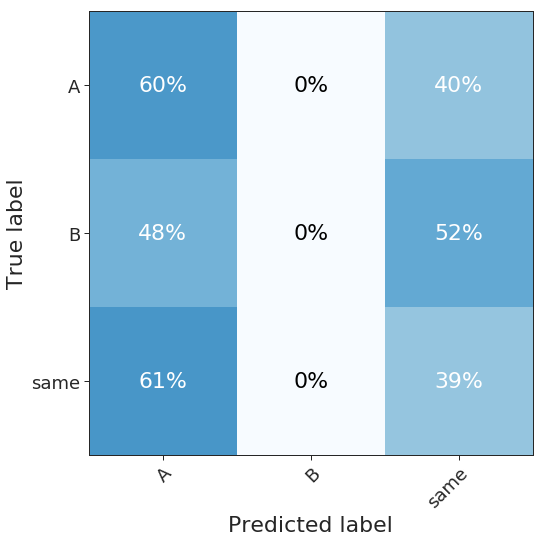

In [12]:
model_path = "models/yoked_tl_mass_dual_model.pt"
scaler_path = "scalers/yoked_dual_scaler.sk"
question_type = "mass"

class_columns = [list(MASS_CLASS_COLS), list(FORCE_CLASS_COLS)]

accuracy, predicted, test_loader = evaluate_saved_model(model_path, network_params, None, trials=test_trials,
                                                       training_columns=BASIC_TRAINING_COLS, class_columns=class_columns,
                                                       scaler_path=scaler_path, arch=MultiBranchModel, multiclass=True,
                                                       device=device, return_test_loader=True, seq_start=None,
                                                       seq_end=1800, step_size=3)
multiclass_index = 0
mass_accuracy = accuracy[multiclass_index]
mass_predicted = predicted[:, multiclass_index]


plot_path = directory+"mass_cm.pdf"
ax = plot_confusion_matrix_given_predicted_and_test_loader(mass_predicted, test_loader, MASS_CLASS_COLS, 
                                                          save_plot_path=plot_path, multiclass_index=multiclass_index)

100%|██████████| 128/128 [00:00<00:00, 507.25it/s]


Model's accuracy on test set: [29.6875 34.375 ]


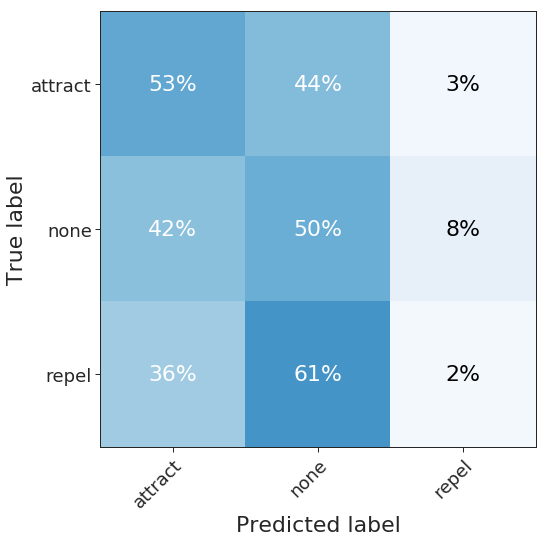

In [13]:
model_path = "models/yoked_tl_force_dual_model.pt"
scaler_path = "scalers/yoked_dual_scaler.sk"
question_type = "mass"

class_columns = [list(MASS_CLASS_COLS), list(FORCE_CLASS_COLS)]

accuracy, predicted, test_loader = evaluate_saved_model(model_path, network_params, None, trials=test_trials,
                                                       training_columns=BASIC_TRAINING_COLS, class_columns=class_columns,
                                                       scaler_path=scaler_path, arch=MultiBranchModel, multiclass=True,
                                                       device=device, return_test_loader=True, seq_start=None,
                                                       seq_end=1800, step_size=3)
multiclass_index = 1
mass_accuracy = accuracy[multiclass_index]
mass_predicted = predicted[:, multiclass_index]


plot_path = directory+"force_cm.pdf"
ax = plot_confusion_matrix_given_predicted_and_test_loader(mass_predicted, test_loader, FORCE_CLASS_COLS, 
                                                          save_plot_path=plot_path, multiclass_index=multiclass_index)